# Task1

## Importing the required libraries. 

In [1]:
import pandas as pd
import re
import nltk
import string
import numpy as np
import itertools
import matplotlib.pyplot as plt
import keras

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding,Conv1D,MaxPooling1D,Bidirectional,LSTM,Dropout,Dense,ActivityRegularization
from keras.losses import BinaryCrossentropy
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping 
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score



## Reading the data as a pandas dataframe. 

In [2]:
raw_ds = pd.read_csv('CVAssignmentDataset.csv')
raw_ds.head()

,Class,Text
0,1,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,1,RT @WinterHavenSun: Winter Haven resident / Al...
2,1,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,1,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,1,RT @Vegalteno: Hurricane season starts on June...


## Exploring the data. 

In [3]:
pd.set_option('display.max_colwidth', None) #To get the maximum width of column.
raw_ds.head()

,Class,Text
0,1,"Today, Senate Dems vote to #SaveTheInternet. Proud to support similar #NetNeutrality legislation here in the House… https://t.co/n3tggDLU1L"
1,1,RT @WinterHavenSun: Winter Haven resident / Alta Vista teacher is one of several recognized by @RepDarrenSoto for National Teacher Apprecia…
2,1,RT @NBCLatino: .@RepDarrenSoto noted that Hurricane Maria has left approximately $90 billion in damages. \n\nCongress has allocated about $18…
3,1,RT @NALCABPolicy: Meeting with @RepDarrenSoto . Thanks for taking the time to meet with @LatinoLeader ED Marucci Guzman. #NALCABPolicy2018.…
4,1,RT @Vegalteno: Hurricane season starts on June 1st; Puerto Rico’s readiness...well 🤦🏼‍♂️😡😩@Pwr4PuertoRico @RepDarrenSoto @EspaillatNY


In [4]:
raw_ds.describe()

,Class,Text
count,86461,86460
unique,3,84502
top,0,"RT @RepDanKildee: Four years later, Flint families are still recovering from the water crisis and having to use filters &amp; bottled water. In…"
freq,44392,31


## Dropping Nan value. 

In [5]:
print(raw_ds.isna().sum())
raw_ds.dropna(inplace=True)

Class    0
Text     1
dtype: int64


In [6]:
raw_ds['Class'].value_counts() # To get unique values of 'Class' feature.

0    44392
1    42068
Name: Class, dtype: int64

## Assigning text samples and labels. 

In [7]:
text_samples = raw_ds['Text']
labels = raw_ds['Class']
labels = labels.apply(lambda x:int(x)) # Converting string labels into integer type.

## Preprocessing functions to clean, tokenize and pad the data.

In [8]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
Stopwords=set(stopwords.words('english'))

def clean_data(text):
    text = re.sub(r"http\S+", "", text) #Removes links in the text
    text = re.sub(r"@", "at",text) #Converts '@' symbol to 'at'
    text = re.sub(r'[^\x00-\x7f]','', text) # Removes all Non-ASCII characters.
    html = BeautifulSoup(text,'lxml') #Removes html character references like '&amp' 
    text = html.get_text()
    
    text = text.strip().lower() 
    
    punctuation = string.punctuation
    punctuation_dict = dict((c,"") for c in punctuation)
    punctuation_map = str.maketrans(punctuation_dict)
    text = text.translate(punctuation_map)  #Removes punctuation from text.
    
    text = ' '.join(word for word in text.split() if word not in Stopwords)
    
    return text

In [9]:
def tokenization(standardized_text,Max_vocab,Max_length):   
    tokenizer = keras.preprocessing.text.Tokenizer(num_words=Max_vocab,filters=string.punctuation)
    tokenizer.fit_on_texts(standardized_text)

    tokenized_text = tokenizer.texts_to_sequences(standardized_text)
    padded_tokenized_text = keras.preprocessing.sequence.pad_sequences(tokenized_text,maxlen=Max_length)
    
    return padded_tokenized_text,tokenizer

## Splitting the data into train and test sets. 

In [11]:
X_train,X_test,y_train,y_test = train_test_split(text_samples,labels,train_size=0.9,random_state=123) # There are enough samples for us to do 90:10 split.

In [12]:
print('Shape of X_train :',X_train.shape)
print('Shape of X_test  :',X_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_test  :',y_test.shape)

Shape of X_train : (77814,)
Shape of X_test  : (8646,)
Shape of y_train : (77814,)
Shape of y_test  : (8646,)


## Cleaning data. 

In [13]:
train_cleaned = X_train.apply(clean_data)
test_cleaned = X_test.apply(clean_data)

## Tokenizing and padding data. 

In [17]:
Max_vocab = 10000
Max_length = 50
Embedding_dim= 32

In [18]:
train_samples,tokenizer = tokenization(train_cleaned,Max_vocab,Max_length)
test_tokenized = tokenizer.texts_to_sequences(test_cleaned)
test_samples = keras.preprocessing.sequence.pad_sequences(test_tokenized,maxlen=Max_length) 

In [19]:
print(train_samples.shape,test_samples.shape,y_test.shape,y_test.shape)

(77814, 50) (8646, 50) (8646,) (8646,)


## Defining the model. 

In [ ]:
model = Sequential()

model.add(Embedding(Max_vocab,Embedding_dim,input_length= train_samples.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding = 'same',activation='relu'))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(256,return_sequences = True,activation = 'relu')))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(256,activation = 'relu')))
model.add(Dropout(0.3))
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'sigmoid'))


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 512)           591872    
_________________________________________________________________
dropout (Dropout)            (None, 25, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

## Compiling and training the model. 

In [22]:
model.compile(loss = BinaryCrossentropy(),optimizer=optimizers.Adam(),metrics=['accuracy'])

epochs= 10
batch_size=32
callbacks=EarlyStopping(monitor='val_loss',patience=3) 

history=model.fit(train_samples, y_train, 
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=callbacks
                  )

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1946/1946 [==============================] - ETA: 0s - loss: 0.5154 - accuracy: 0.7204WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000224551AF558> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=1

In [23]:
model.save('model.h5')

## Predicting on train and test data. 

In [ ]:
train_predictions = (model.predict(train_samples) > 0.5).astype("int32")
test_predictions = (model.predict(test_samples) > 0.5).astype("int32")

## Plotting training accuracy. 

Text(0.5, 1.0, 'Accuracy Curves')

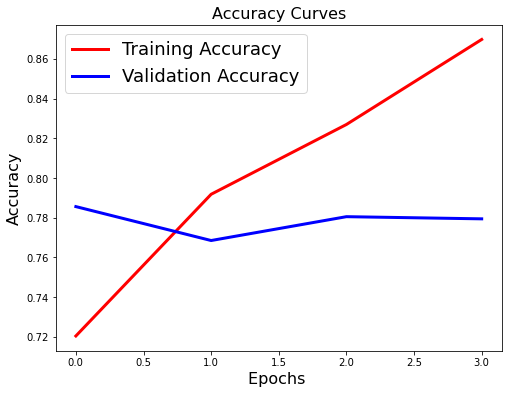

In [25]:
plt.figure(figsize=[8,6])

plt.plot(history.history['accuracy'],'r',linewidth=3.0)

plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)

plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)

plt.title('Accuracy Curves',fontsize=16)

## Test Accuracy: 

In [26]:
print("Test Accuracy is : ",accuracy_score(y_test,test_predictions))

Test Accuracy is :  0.7692574600971548


## Function for plotting confusion matrix(from sklearn documentation) 

In [27]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')



## Plotting the confusion matrix.

Confusion matrix, without normalization


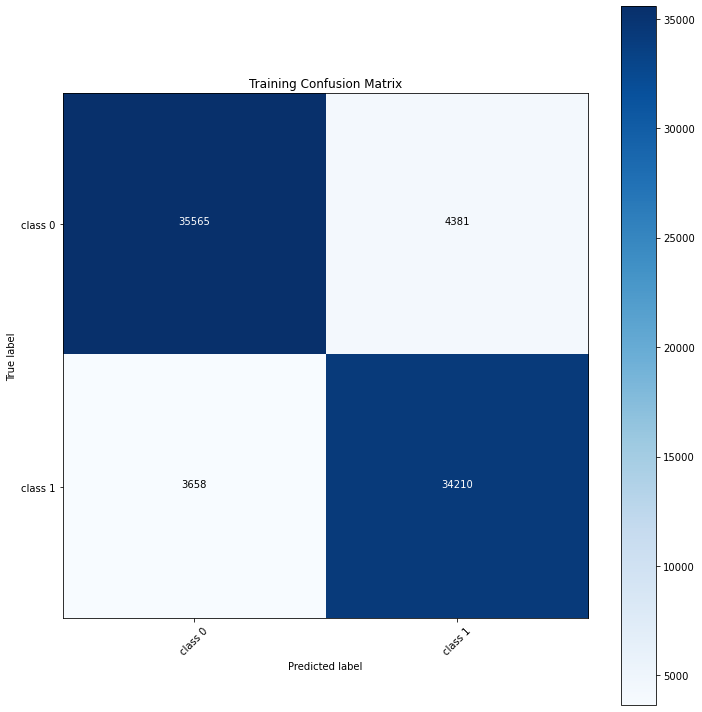

In [28]:
train_cm = confusion_matrix(y_train, train_predictions)
cm_plot_labels = ['class 0','class 1']
plot_confusion_matrix(cm=train_cm, classes=cm_plot_labels, title='Training Confusion Matrix')

Confusion matrix, without normalization


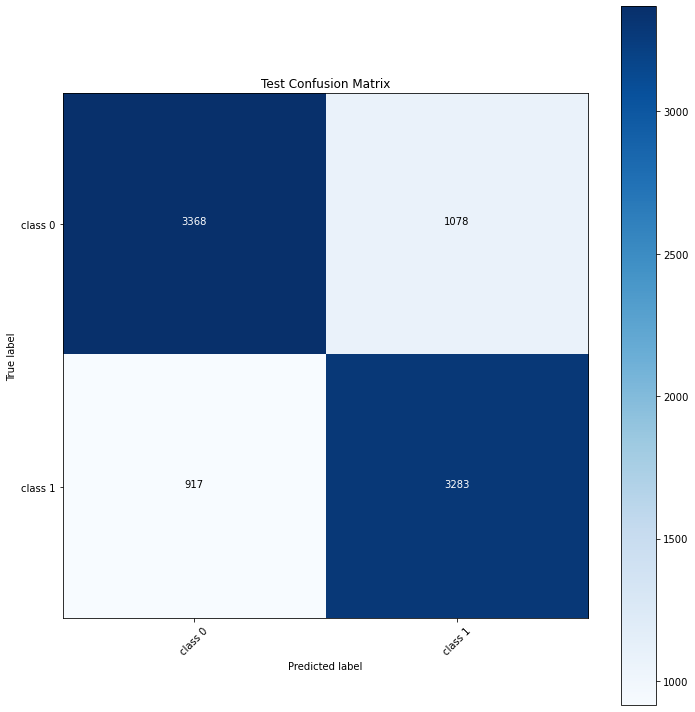

In [29]:
test_cm = confusion_matrix(y_test, test_predictions)
cm_plot_labels = ['class 0','class 1']
plot_confusion_matrix(cm=test_cm, classes=cm_plot_labels, title='Test Confusion Matrix')

## Calculating Matthews Correlation Coefficient .

In [30]:
train_mcc = matthews_corrcoef(y_train, train_predictions)
test_mcc = matthews_corrcoef(y_test, test_predictions)

In [31]:
print("Training Matthews Correlation Coefficient is : ",train_mcc)
print("Test Matthews Correlation Coefficient is : ",test_mcc)

Training Matthews Correlation Coefficient is :  0.7934713307872834
Test Matthews Correlation Coefficient is :  0.5390040560925938
